# Atividade prática III - Sistemas Nebulosos

#### Universidade Federal de Minas Gerais

#### Prof. Cristiano Leite de Castro

---

Matheus Brito Faria - 2017074386


## Importação de bibliotecas

In [1]:
import sys
import itertools
import numpy as np
import pandas as pd
from scipy.io import loadmat
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

Para essa análise é necessário que a versão do pyTorch seja a 1.0.1, caso contrário os códigos utilizados podem não possuir o comportamento esperado.

Para instalar essa versão usando pip é só descomentar a primeira linha do da célula a seguir.

In [2]:
# !pip install torch===1.0.1 -f https://download.pytorch.org/whl/torch_stable.html
import torch
from torch.utils.data import TensorDataset, DataLoader
print(torch.__version__)

1.0.1


Importando a implementação do ANFIS usando pyTorch disponível [nesse repositório](https://github.com/jfpower/anfis-pytorch).

In [3]:
%cd /content/drive/MyDrive/UFMG/8º SEMESTRE/SISTEMAS NEBULOSOS/tp-3/Matheus_Faria

import anfis
from experimental import train_anfis, test_anfis, plot_all_mfs
from membership import BellMembFunc, GaussMembFunc,\
    make_gauss_mfs, make_bell_mfs, make_tri_mfs, make_trap_mfs

/content/drive/MyDrive/UFMG/8º SEMESTRE/SISTEMAS NEBULOSOS/tp-3/Matheus_Faria


Definindo algumas varáveis e parâmetros usados no código.

In [4]:
pi = np.pi
dtype = torch.float
plt.rcParams["figure.figsize"] = [12,7]

##  Problema: Aproximação de uma Função 

Criação da função a ser aproximada.

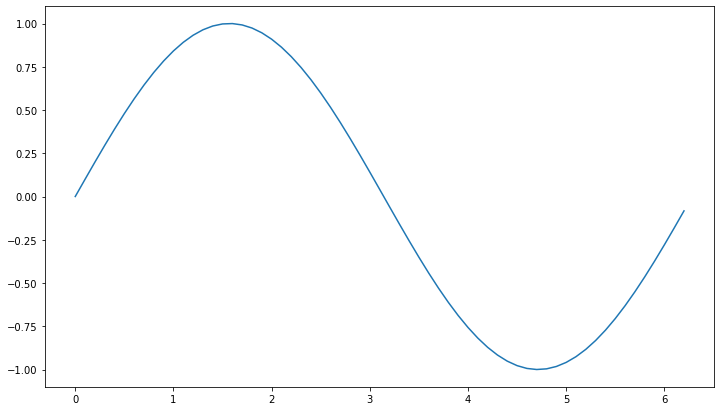

In [5]:
def make_sin():
    x = np.arange(0, 2*pi, 0.1)
    y = np.sin(x)
    return (x, y)

x, y = make_sin()
plt.plot(x, y)
plt.show()

Foi adicionado um ruído guassiano com média zero e variância de 0.1 nas amostras da função a ser aproximada.

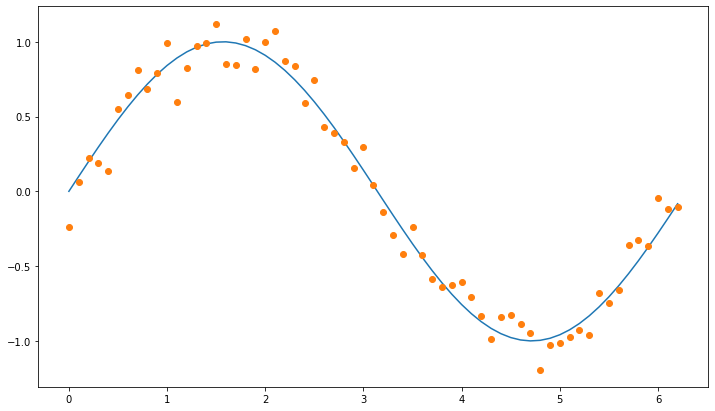

In [6]:
def add_some_noise(y, mu=0, sigma=1.0):
    s = np.random.normal(mu, sigma, y.shape[0])
    y_with_noise = y + s
    return y_with_noise

y_with_noise = add_some_noise(y, mu=0, sigma=0.1)

plt.plot(x, y)
plt.plot(x, y_with_noise, 'o')
plt.show()

Criação do modelo que será utilizado passando um valor inicial de sigma e um valor de média para cada uma das funções de pertinência.

Nesse caso sigma com o valor de 2 e as médias sendo 0 e 2*pi.

In [7]:
def sin_model():
    invardefs = [('x0', make_gauss_mfs(2, [0, 2*pi]))]
    outvars = ['y0']
    anf = anfis.AnfisNet('Sin model', invardefs, outvars)
    return anf


model = sin_model()

Criação do dataloader dos dados ruidosos.

In [8]:
def create_dataloader(x, y, batch_size=1024):
    '''
        Generates a set of (x, y) values for the sync function.
        Uses a large data set so we can test mini-batch in action.
    '''
    x = torch.tensor([[p] for p in x], dtype=dtype)
    y = torch.tensor([[p] for p in y], dtype=dtype)
    td = TensorDataset(x, y)
    return DataLoader(td, batch_size=batch_size, shuffle=True)

train_data = create_dataloader(x, y_with_noise)

Treinamento do ANFIS para geração das melhores funções de pertinência usando 200 épocas.

Durante o treinamento é possível observar a cada 10 épocas o erro quadrático médio ir decaindo e chegando ao valor de 0.00917.

O gráfico seguinte também mostra o comportamento da porcentagem de erro das amostras durante as épocas. Lembrando que as amostras que estão sendo usadas de base possuem ruído. Colocar mais épocas no modelo não melhorou sua resposta pois provavelmente o algoritmo de otimização chegou em um mínimo local.

O próximo gráfico mostra uma comparação entre as amostras utilizadas e o modelo aproximado, podemos observar que apesar das amostras com ruido, o comportamento da senoide ficou bem representado.

### Training for 200 epochs, training size = 63 cases
epoch    0: MSE=0.01955, RMSE=0.13981 =36.73%
epoch   10: MSE=0.01943, RMSE=0.13940 =36.57%
epoch   20: MSE=0.01913, RMSE=0.13833 =36.13%
epoch   30: MSE=0.01869, RMSE=0.13673 =35.47%
epoch   40: MSE=0.01816, RMSE=0.13475 =34.65%
epoch   50: MSE=0.01757, RMSE=0.13255 =33.73%
epoch   60: MSE=0.01696, RMSE=0.13024 =32.74%
epoch   70: MSE=0.01637, RMSE=0.12794 =31.73%
epoch   80: MSE=0.01580, RMSE=0.12572 =30.73%
epoch   90: MSE=0.01529, RMSE=0.12363 =30.04%
epoch  100: MSE=0.01482, RMSE=0.12173 =29.43%
epoch  110: MSE=0.01441, RMSE=0.12003 =29.12%
epoch  120: MSE=0.01405, RMSE=0.11853 =28.99%
epoch  130: MSE=0.01374, RMSE=0.11722 =28.87%
epoch  140: MSE=0.01348, RMSE=0.11611 =28.77%
epoch  150: MSE=0.01327, RMSE=0.11517 =28.71%
epoch  160: MSE=0.01309, RMSE=0.11439 =28.65%
epoch  170: MSE=0.01294, RMSE=0.11374 =28.61%
epoch  180: MSE=0.01282, RMSE=0.11321 =28.58%
epoch  190: MSE=0.01272, RMSE=0.11278 =28.55%


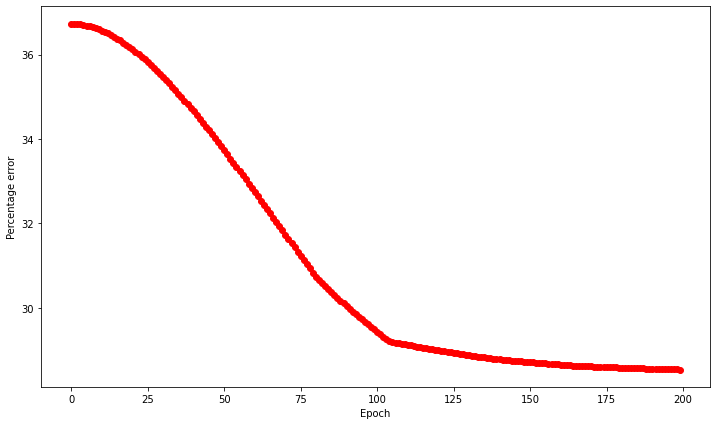

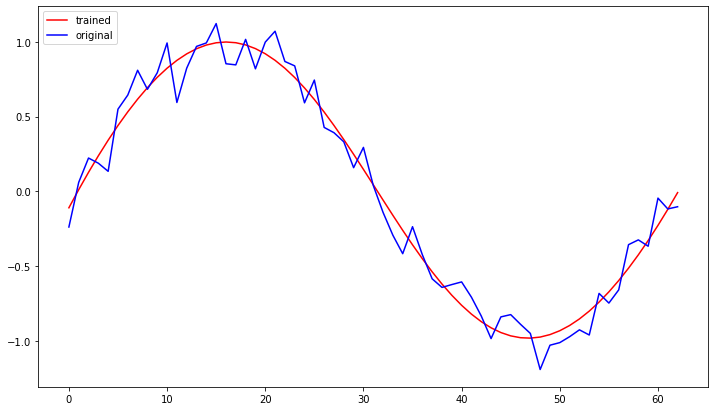

In [9]:
train_anfis(model, train_data, 200, True)

Comparando o resultado do modelo com a senóide original e com as amostras utilizadas podemos concluir que o modelo se adequou bem ao originais mesmo com ruído.

O MSE confirma essa afirmação visto que seu valor calculado considerando as amostras sem ruído algum foi de 0.00097.

The MSE based on the original data is 0.0010178866951474112



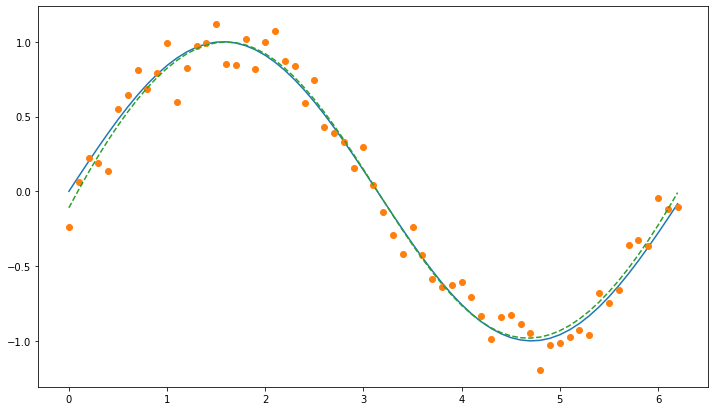

In [10]:
x_tensor = torch.tensor([[p] for p in x])
y_predict = model.forward(x_tensor)
y_predict = y_predict.detach().numpy()

print(f'The MSE based on the original data is {mean_squared_error(y, y_predict)}\n')

plt.plot(x, y)
plt.plot(x, y_with_noise, 'o')
plt.plot(x, y_predict, '--')
plt.show()

## Problema: Previsao de uma Série Temporal 

Fazendo a importação do dados e verificando a quantidade de observações da série temporal de Mackey-Glass como a equação que se segue

\\[ \dot{x} = \frac{0.2x(t-\Delta)}{1 + x^{10}(t-\Delta)} -0.1x(t) \\]

In [11]:
data = loadmat('mg.mat')
data = pd.DataFrame(data['x'])
lendata = len(data)
print('Numero de obervacoes da serie temporal: ', lendata)

Numero de obervacoes da serie temporal:  1001


Separando os dados em conjuntos de treino e teste para uma futura avaliação dos resultados, para isso foram usados 80% para treino e o restante para teste.

Como os dados a serem previstos são de uma série temporal é importante manter a ordem em que eles foram coletados.

In [12]:
train_percentage = .8
data_train = data[:int(lendata*train_percentage)][0]
data_test = data[int(lendata*train_percentage):][0].reset_index(drop=True)

Para a criação do dataloader os dados foram organizados de tal maneira que seja analisada a saída como um valor da série temporal seis passos a frente e as entradas como os valores da série temporal no passo atual, seis passos atrás, doze passos atrás e dezoito passos atrás da seguinte maneira.


> Entradas: `x(t-18), x(t-12), x(t-6), x(t)`



> Saída: `x(t+6)`





In [13]:
def create_dataloader(data, batch_size=1024):

    x = torch.tensor([[data[index-18],
                       data[index-12], 
                       data[index-6], 
                       data[index]] 
                      for index in range(18, len(data)-6)], dtype=dtype)
    
    y = torch.tensor([[data[index+6]]
                      for index in range(18, len(data)-6)], dtype=dtype)
    
    td = TensorDataset(x, y)
    return DataLoader(td, batch_size=batch_size)

train_dataloader = create_dataloader(data_train)
test_dataloader = create_dataloader(data_test)

Para a criação do modelo ANFIS foram criadas duas funções de pertinência do tipo guaussiana para cada uma das quatro variáveis do sistema em que todas elas foram inicializadas com o sigma (desvio padrão) de 0.1 e médias de 0.5 e 1 em cada uma das variáveis.

In [14]:
def anfis_model():
    standard_deviation = .1
    mean = [.5, 1]
    invardefs = [
                 ('x0', make_gauss_mfs(standard_deviation, mean)),
                 ('x1', make_gauss_mfs(standard_deviation, mean)),
                 ('x2', make_gauss_mfs(standard_deviation, mean)),
                 ('x3', make_gauss_mfs(standard_deviation, mean))
                 ]
    outvars = ['y0']
    anf = anfis.AnfisNet('ANFIS model', invardefs, outvars)
    return anf


model = anfis_model()

Foi feito o treinamento usando 200 épocas e o erro médio quadrático das amostras de treino ficou em torno de 0.00001, junto disso é possível observar o comportamento do erro pertecentual no primeiro gráfico, onde a partir de 125 épocas praticamente o erro se manteve constante.

No gráfico seguinte é possível observar que o modelo se ajustou muito bem os dados da série temporal, onde as linhas azul e vermelhas estão praticamente sobrepostas.

### Training for 200 epochs, training size = 776 cases
epoch    0: MSE=0.00023, RMSE=0.01530 =1.34%
epoch   10: MSE=0.00022, RMSE=0.01484 =1.29%
epoch   20: MSE=0.00019, RMSE=0.01373 =1.17%
epoch   30: MSE=0.00015, RMSE=0.01215 =1.01%
epoch   40: MSE=0.00010, RMSE=0.01020 =0.82%
epoch   50: MSE=0.00007, RMSE=0.00821 =0.72%
epoch   60: MSE=0.00004, RMSE=0.00649 =0.56%
epoch   70: MSE=0.00005, RMSE=0.00741 =0.64%
epoch   80: MSE=0.00003, RMSE=0.00528 =0.46%
epoch   90: MSE=0.00002, RMSE=0.00432 =0.39%
epoch  100: MSE=0.00002, RMSE=0.00436 =0.36%
epoch  110: MSE=0.00002, RMSE=0.00432 =0.34%
epoch  120: MSE=0.00002, RMSE=0.00430 =0.33%
epoch  130: MSE=0.00002, RMSE=0.00424 =0.32%
epoch  140: MSE=0.00002, RMSE=0.00415 =0.32%
epoch  150: MSE=0.00002, RMSE=0.00405 =0.31%
epoch  160: MSE=0.00002, RMSE=0.00395 =0.31%
epoch  170: MSE=0.00001, RMSE=0.00387 =0.30%
epoch  180: MSE=0.00001, RMSE=0.00378 =0.30%
epoch  190: MSE=0.00001, RMSE=0.00370 =0.29%


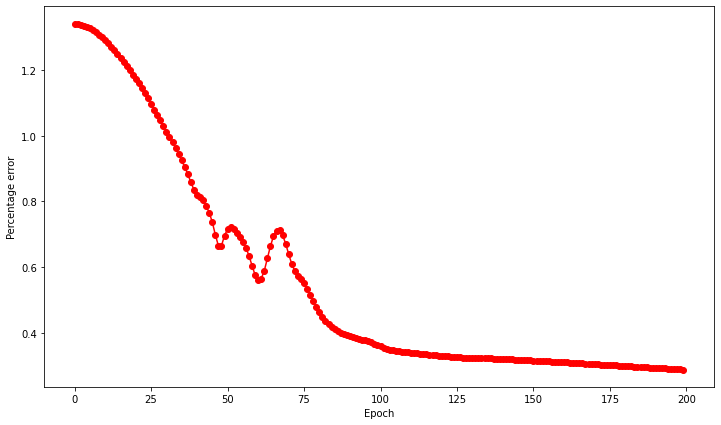

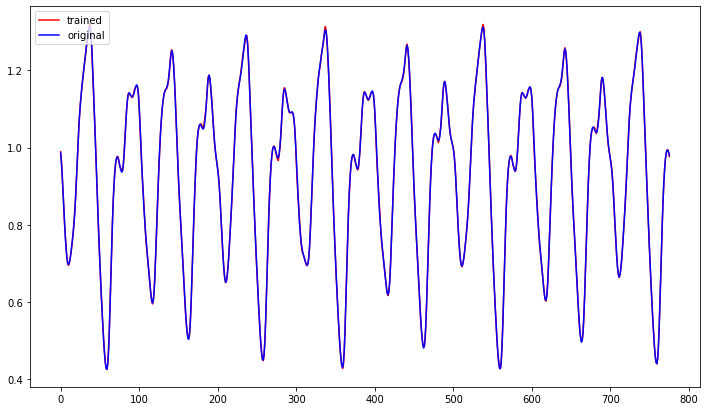

In [15]:
train_anfis(model, train_dataloader, 200, True)

Para fazer a validação do modelo foi usados os dados de teste, dessa forma foram plotados as funções de pertenência encontradas para cada uma das variáveis, e por fim é mostrado os dados de teste e os resultados do modelo onde o MSE foi de 0.00002 com 0.30% de erro e as curvas que novamente estão praticamente sobrepostas.

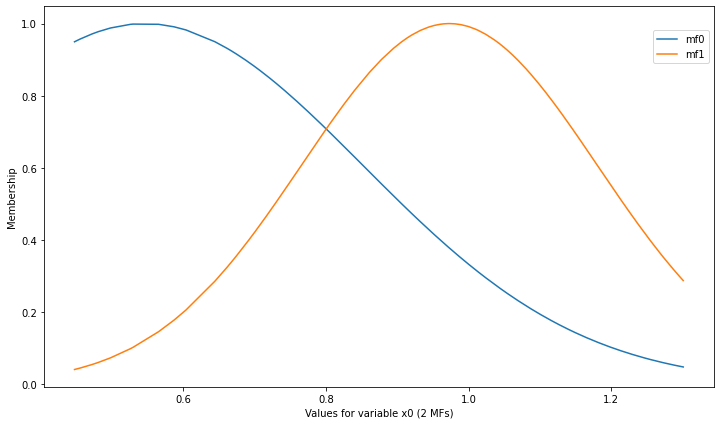

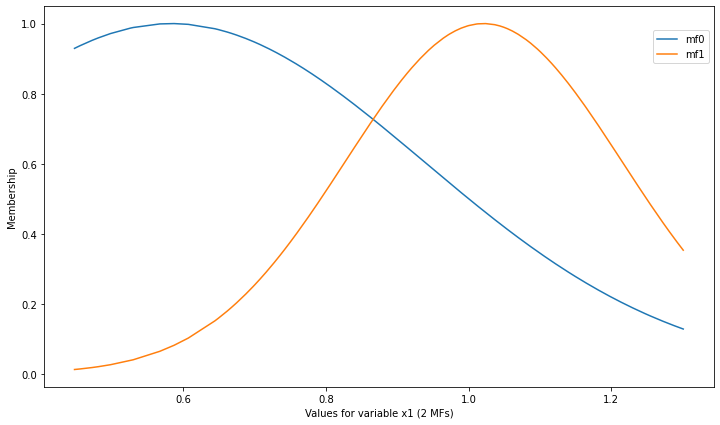

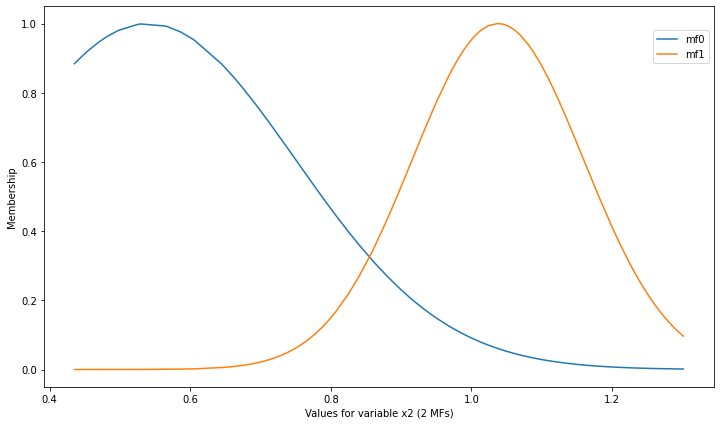

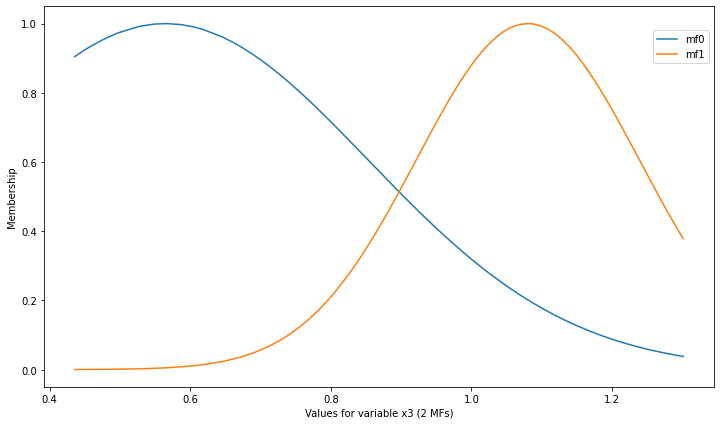

### Testing for 177 cases
MS error=0.00002, RMS error=0.00390, percentage=0.30%


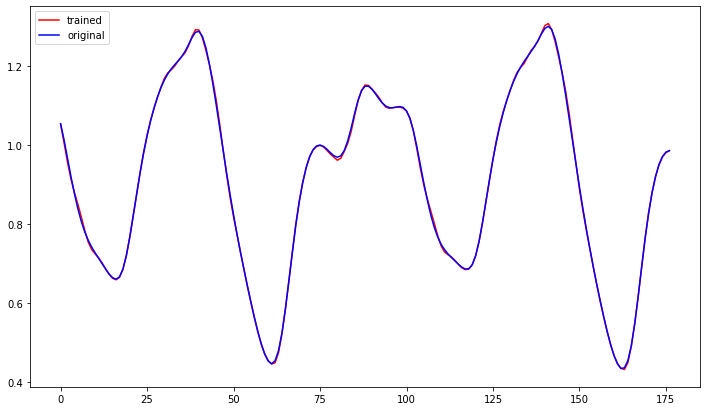

In [16]:
test_anfis(model, test_dataloader, show_plots=True)